In [3]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down

import warnings
warnings.filterwarnings('ignore')

## Export Number of wet days, Weibull Parameters and Quantiles
### Quantiles_OBS info about the stations and quantiles for all period
### WEIBULL_OBS Wet days, Weibull parameters for each year

In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [5]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Veneto','BACKUP_RAW','VENETO_INFO_1dy.csv')

if os.path.exists(OBS_INFO_dir):
    INFO_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [6]:
# def Quantile_manual(Tr, N, C, W):
#     '''
#     For multiples values of N, C and W
#     '''
#     QQ = np.zeros([len(N),len(Tr)])
#     for nn in range(len(Tr)):
#         annual_non_exceed_prob = 1 - 1/np.array(Tr[nn])
#         daily_non_exceed_prob = annual_non_exceed_prob ** (1 / N)
#         inside_log = 1 - daily_non_exceed_prob
#         quantiles = C * (-np.log(inside_log)) ** (1 / W)
#         QQ[:, nn] = quantiles
#     return QQ

# def Quantile_manual_single(Tr, N, C, W):
#     '''
#     Only for single values of N, C and W
#     '''
#     QQ = np.zeros([len(Tr)])
#     for nn in range(len(Tr)):
#         annual_non_exceed_prob = 1 - 1/np.array(Tr[nn])
#         daily_non_exceed_prob = annual_non_exceed_prob ** (1 / N)
#         inside_log = 1 - daily_non_exceed_prob
#         quantiles = C * (-np.log(inside_log)) ** (1 / W)
#         QQ[nn] = quantiles
#     return QQ

In [7]:
names, lats, lons, yys, yye, nys, elev, Ns, Cs, Ws = [], [], [], [], [], [], [], [], [], []

for nn in range(len(INFO_pd)):
    RAIN_pd = pd.read_csv(os.path.join(OBS_base,'Veneto','BACKUP_RAW','CLEAR_1dy', f'{INFO_pd['File_Name'].values[nn]}.csv'), sep=',')
    RAIN_pd['TIME'] = pd.to_datetime(RAIN_pd['TIME'].values)
    ss, ee = RAIN_pd['TIME'][0].year, RAIN_pd['TIME'][len(RAIN_pd['TIME'])-1].year
    ny = (ee-ss)+1

    names.append(INFO_pd['File_Name'].values[nn])
    lats.append(INFO_pd['Lat'].values[nn])
    lons.append(INFO_pd['Lon'].values[nn])
    yys.append(ss)
    yye.append(ee)
    nys.append(ny)
    elev.append(INFO_pd['Elv'].values[nn])

Quantiles_OBS = pd.DataFrame({'File_Name':names, 
                    'Lat':lats, 'Lon':lons, 
                    'YYS':yys, 'YYE':yye, 
                    'Elv':elev,'NY':nys})

In [9]:
names, lats, lons, Q10, Q20, Q50, Q100 = [], [], [], [], [], [], []

q10_M1, q20_M1, q50_M1, q100_M1 = [], [], [], [] # using mean of N, S and W
q10_M2, q20_M2, q50_M2, q100_M2 = [], [], [], [] # using mean of N, S and W

for nn in range(len(Quantiles_OBS)):
    filename = f'{Quantiles_OBS['File_Name'].values[nn]}.csv'
    RAIN_pd = pd.read_csv(os.path.join(OBS_base,'Veneto','BACKUP_RAW','CLEAR_1dy', filename), sep=',')
    RAIN_pd['TIME'] = pd.to_datetime(RAIN_pd['TIME'].values)
    ss, ee = RAIN_pd['TIME'][0].year, RAIN_pd['TIME'][len(RAIN_pd['TIME'])-1].year
    ny = (ee-ss)+1
    year_list = np.arange(ss,ee+1)

    if ny != len(year_list):
        raise SystemExit(f"ERROR years with differents lenghts")

    RAIN_xr = xr.DataArray(
                    RAIN_pd['PRE'].values,
                    coords={'time':RAIN_pd['TIME'].values}, 
                    dims=('time'))

    NCW = ART_down.fit_yearly_weibull_update(RAIN_xr,1)
    N = NCW[:,0]
    C = NCW[:,1]
    W = NCW[:,2]
    Y = NCW[:,3].astype('int')

    Tr = [10, 20, 50, 100]
    Fi = 1 - 1/np.array(Tr)     
    x0 = np.nanmean(C)
    TMP_Q, _ = ART_down.mev_quant(Fi, 10, N, C, W, thresh=1)
    Q10.append(np.round(TMP_Q[0],4))
    Q20.append(np.round(TMP_Q[1],4))
    Q50.append(np.round(TMP_Q[2],4))
    Q100.append(np.round(TMP_Q[3],4))
    
    WEIBULL_OBS = pd.DataFrame({
                            'Y': Y,
                            'N': N,
                            'C': C,
                            'W': W})

    QQ = ART_down.Quantile_manual_general(Tr, N, C, W)
    WEIBULL_OBS['Q10'] = QQ[:, 0]
    WEIBULL_OBS['Q20'] = QQ[:, 1]
    WEIBULL_OBS['Q50'] = QQ[:, 2]
    WEIBULL_OBS['Q100'] = QQ[:, 3]

    nameout = filename.replace('.csv','_WQ.csv')
    WEIBULL_OBS.to_csv(os.path.join(OBS_base,'Weibull','Veneto',nameout), index=False)

    q10_M1.append(np.nanmean(QQ[:, 0]))
    q20_M1.append(np.nanmean(QQ[:, 1]))
    q50_M1.append(np.nanmean(QQ[:, 2]))
    q100_M1.append(np.nanmean(QQ[:, 3]))
    
    SINGLE = ART_down.Quantile_manual_general(Tr,np.nanmean(N),np.nanmean(C),np.nanmean(W))
    q10_M2.append(SINGLE[0])
    q20_M2.append(SINGLE[1])
    q50_M2.append(SINGLE[2])
    q100_M2.append(SINGLE[3])

Quantiles_OBS['Q10'] = Q10
Quantiles_OBS['Q20'] = Q20
Quantiles_OBS['Q50'] = Q50
Quantiles_OBS['Q100'] = Q100

# Mean of quantiles from manual method
Quantiles_OBS['Q10_M1'] = q10_M1
Quantiles_OBS['Q20_M1'] = q20_M1
Quantiles_OBS['Q50_M1'] = q50_M1
Quantiles_OBS['Q100_M1'] = q100_M1

# Mean of wet days and weibull parameters from manual method
Quantiles_OBS['Q10_M2'] = q10_M2
Quantiles_OBS['Q20_M2'] = q20_M2
Quantiles_OBS['Q50_M2'] = q50_M2
Quantiles_OBS['Q100_M2'] = q100_M2

Quantiles_OBS.to_csv(os.path.join(OBS_base,'Weibull','Veneto_INFO_WQ.csv'), index=False)

mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - change x0
mev_quant:: ERROR - fsolve does not work - cha

In [10]:
Quantiles_OBS.head(5)

,File_Name,Lat,Lon,YYS,YYE,Elv,NY,Q10,Q20,Q50,Q100,Q10_M1,Q20_M1,Q50_M1,Q100_M1,Q10_M2,Q20_M2,Q50_M2,Q100_M2
0,002_FG_BS,45.895600,12.815000,1995,2022,21,28,132.4365,154.8719,186.0192,211.0015,125.905614,143.381335,166.746735,184.769449,120.394071,136.851413,158.769444,175.615000
1,003_BL_Ar,46.499984,11.876073,1984,2023,1642,40,92.7934,106.9952,126.0768,140.9461,86.012597,97.213472,112.108986,123.544374,82.847942,93.438933,107.473797,118.213509
2,003_FG_BS,45.918000,12.545000,1995,2022,22,28,158.0486,291.6953,636.4766,1007.8025,199.784522,243.471714,308.888940,365.017333,128.456516,146.758216,171.267017,190.196306
3,004-264_NP_Be,46.164679,12.244708,1993,2023,379,31,120.6487,137.5578,160.0625,177.4375,115.169203,129.721724,148.981273,163.702461,113.627100,127.924058,146.818284,161.240956
4,004_NP_Be,46.133632,12.195395,1993,2006,392,14,111.3868,126.9152,147.6461,163.6962,108.940257,122.948818,141.522153,155.741835,106.423979,120.102842,138.207971,152.046921


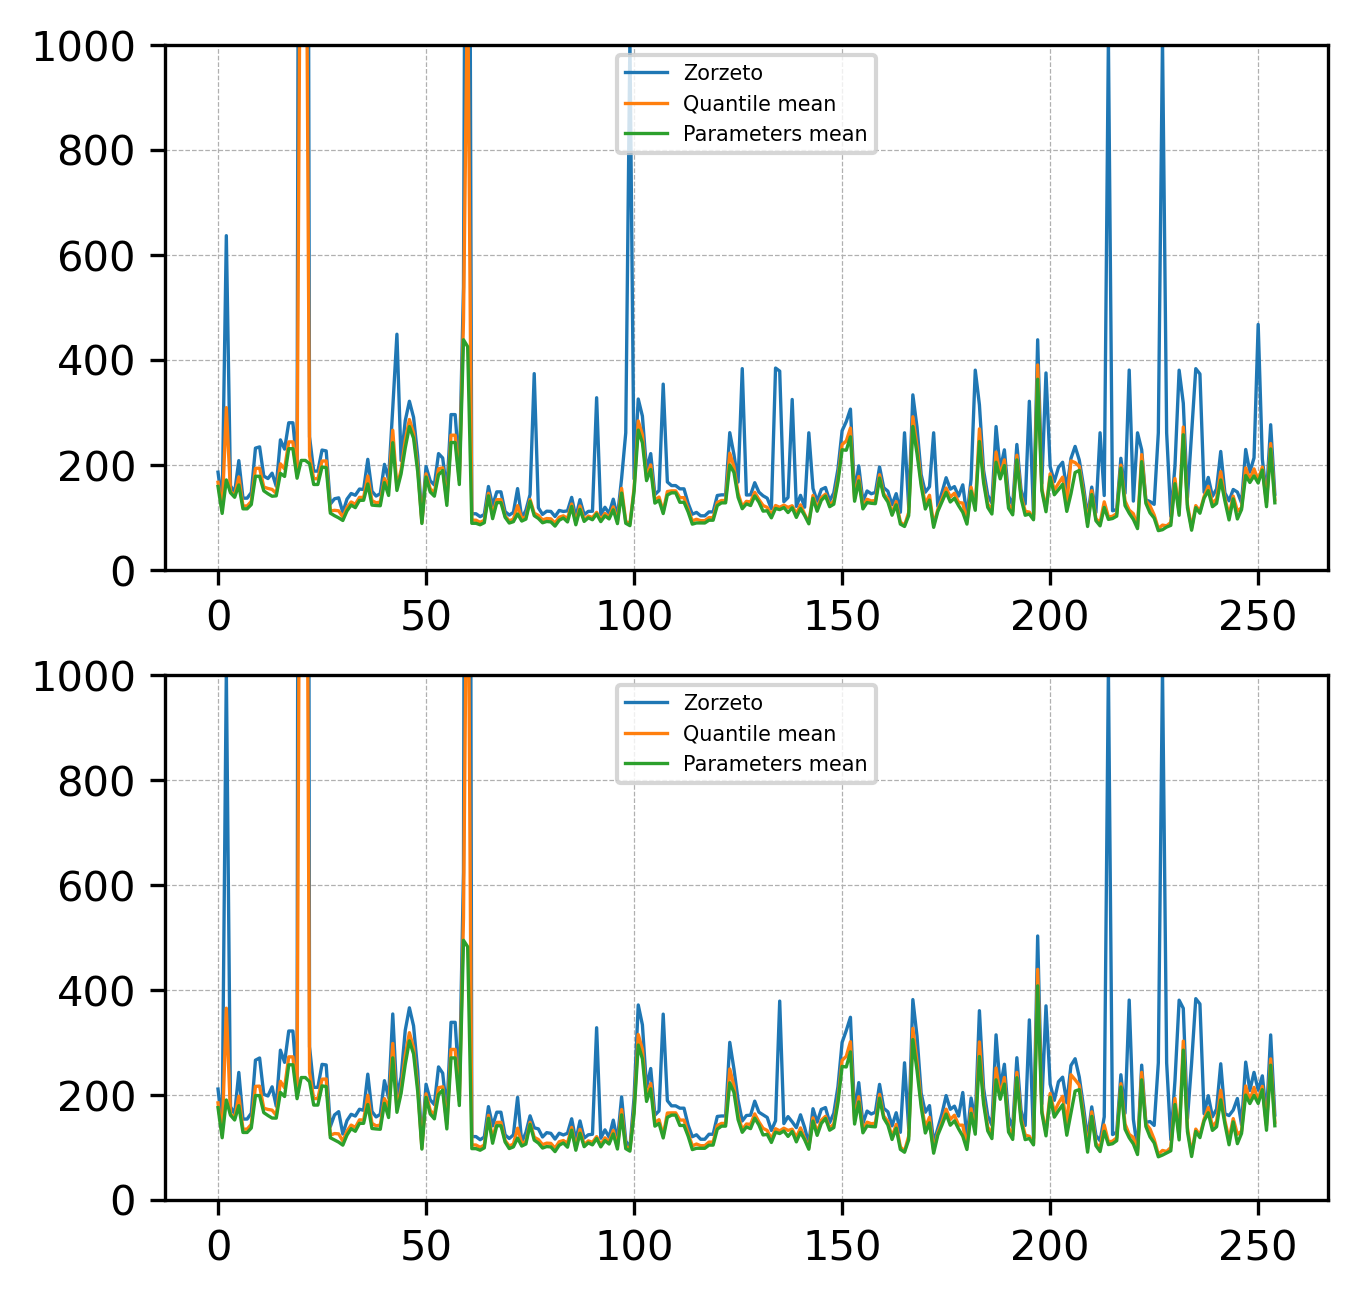

In [31]:
fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(2,1)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(Quantiles_OBS['Q50'], linewidth=0.8, label='Zorzeto')
ax1.plot(Quantiles_OBS['Q50_M1'], linewidth=0.8, label='Quantile mean')
ax1.plot(Quantiles_OBS['Q50_M2'], linewidth=0.8, label='Parameters mean')
ax1.set_ylim(0, 1000)
ax1.legend(fontsize=5, loc=9)
ax1.grid(linewidth=0.3, linestyle='--')

# ==================================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(Quantiles_OBS['Q100'], linewidth=0.8, label='Zorzeto')
ax1.plot(Quantiles_OBS['Q100_M1'], linewidth=0.8, label='Quantile mean')
ax1.plot(Quantiles_OBS['Q100_M2'], linewidth=0.8, label='Parameters mean')
ax1.set_ylim(0, 1000)
ax1.legend(fontsize=5, loc=9)
ax1.grid(linewidth=0.3, linestyle='--')

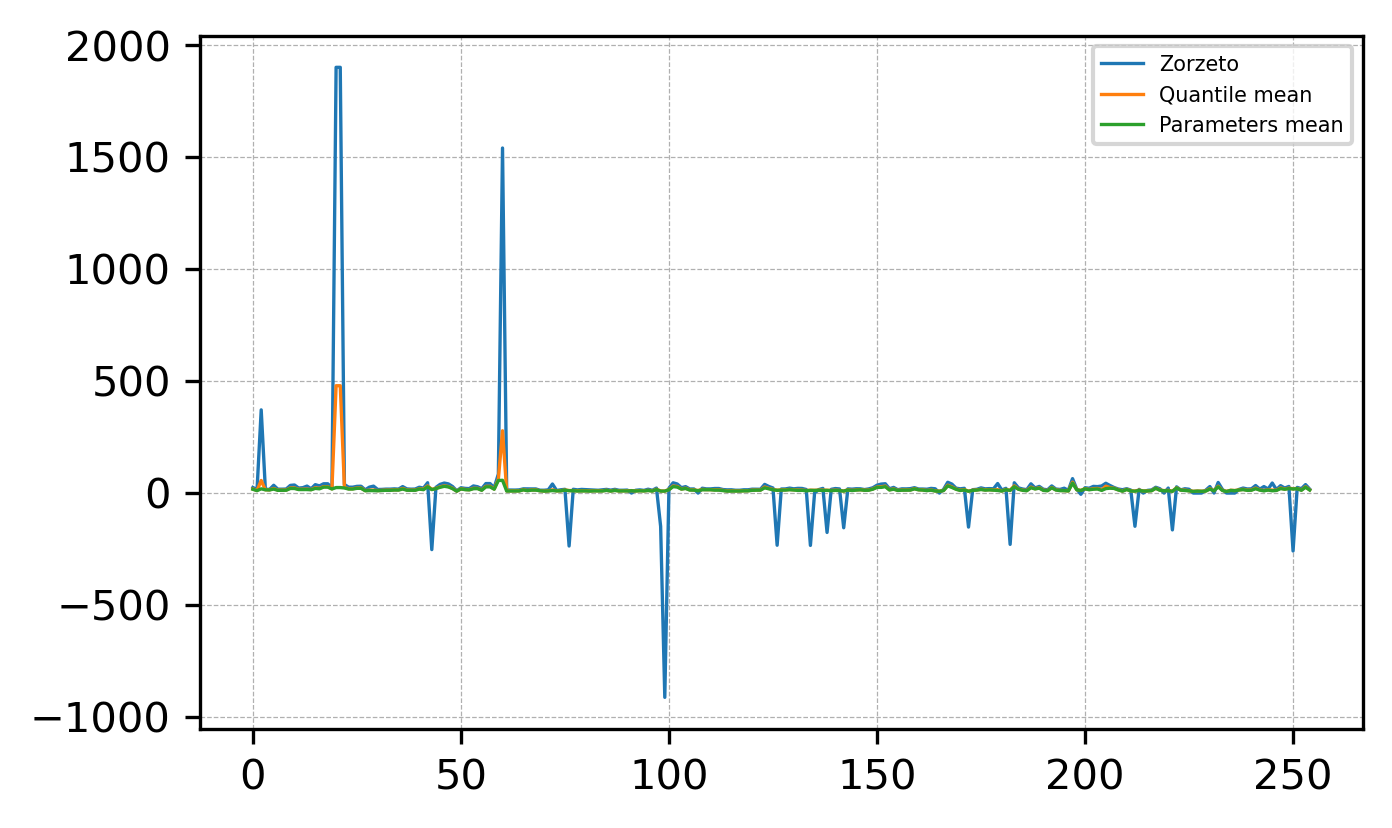

In [32]:
fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(Quantiles_OBS['Q100']- Quantiles_OBS['Q50'], linewidth=0.8, label='Zorzeto')
ax1.plot(Quantiles_OBS['Q100_M1']- Quantiles_OBS['Q50_M1'], linewidth=0.8, label='Quantile mean')
ax1.plot(Quantiles_OBS['Q100_M2']- Quantiles_OBS['Q50_M2'], linewidth=0.8, label='Parameters mean')
# ax1.set_ylim(0, 1000)
ax1.legend(fontsize=5)
ax1.grid(linewidth=0.3, linestyle='--')